<a href="https://colab.research.google.com/github/nicolaiberk/Imbalanced/blob/master/02a_DictionarySampling_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stratified Dictionary Sampling for Imbalanced Data

**The solutions for this notebook can be found [here](https://colab.research.google.com/github/nicolaiberk/Imbalanced/blob/master/02a_DictionarySampling_Solution.ipynb)**.

To address imbalanced data problems we can oversample the minority class from the original (unlabelled) data. One particular method to do this is to define a dictionary related to the concept of interest and select a higher number of observations from samples containing words related to the concept. This works particular well with dictionary extension using embeddings.

We use an imbalanced dataset of articles from the far-right Breitbart news website from [this paper](https://www.cambridge.org/core/services/aop-cambridge-core/content/view/CF6AAF05F465D5BC688A9548433123C1/S1047198720000042a.pdf/active-learning-approaches-for-labeling-text-review-and-assessment-of-the-performance-of-active-learning-approaches.pdf). The articles carry a meta-tag (chosen by the editors of the website) to indicate whether an article contains content relating to 'muslim identity'. We will try to train a classifier to detect these articles.

In [17]:
## load basic packages, data
import pandas as pd
import numpy as np

df = pd.read_csv("https://www.dropbox.com/s/f4uuowcxguudszl/breitbart_data.csv?dl=1")
df = df.sample(10000) # sample

A first inspection of the data reveals many variables, of which we will only use the text and the outcome of interest, 'muslim_identity'.

In [18]:
df.head()

,article_id,article_slug,author,comment_count,href,main_image,modified,published,share_count,tags,title,muslim_identity,text
17263,one-giant-leap-come-on-america-lets-put-a-cong...,one-giant-leap-come-on-america-lets-put-a-cong...,Iowahawk,0.0,http://www.breitbart.com/big-hollywood/2009/07...,NaN,"21 Jul, 2009","21 Jul, 2009",0.0,/big-hollywood/ /tag/congress/ /tag/jerrold-na...,"One Giant Leap: Come on America, Let's Put a C...",0,An Iowahawk Techno-pinion\nby David Burge\n\nI...
20093,review-julie-julia-traditional-filmmaking-with...,review-julie-julia-traditional-filmmaking-with...,Carl Kozlowski,0.0,http://www.breitbart.com/big-hollywood/2009/08...,NaN,"7 Aug, 2009","7 Aug, 2009",0.0,/big-hollywood/,Review: 'Julie & Julia'–Traditional Filmmaking...,0,It’s rare enough these days to see a movie in ...
8355,4663331538,two-islamic-state-chemical-attacks-in-iraq-wou...,Edwin Mora,0.0,http://www.breitbart.com/national-security/201...,http://media.breitbart.com/media/2016/03/iraq-...,"14 Mar, 2016","14 Mar, 2016",965.0,/jihad/ /middle-east/ /national-security/ /tag...,Iraq: Islamic State Chemical Attacks Wound 600...,1,Islamic State (ISIS/ISIL) jihadists have launc...
20060,4493655733,lindsey-graham-set-to-endorse-jeb-bush,Michelle Fields,0.0,http://www.breitbart.com/big-government/2016/0...,http://media.breitbart.com/media/2015/06/Getty...,"15 Jan, 2016","15 Jan, 2016",13881.0,/2016-presidential-race/ /big-government/ /tag...,Lindsey Graham Set To Endorse Jeb Bush,0,"CHARLESTON, S.C. — Sen. Lindsey Graham (R-SC) ..."
9071,5607579722,islamic-state-may-used-chemical-weapons-near-m...,Edwin Mora,0.0,http://www.breitbart.com/national-security/201...,http://media.breitbart.com/media/2016/08/chemi...,"6 Mar, 2017","6 Mar, 2017",259.0,/jerusalem/ /jihad/ /national-security/ /tag/c...,Islamic State Accused of Using ‘Blistering Che...,0,"The medical treatment of women and children, i..."


We split the data into train and test set in order to evaluate it later and delete the initial data.

In [19]:
# train test split
from sklearn.model_selection import train_test_split
____, X_test, _____, _____ = train_test_split(
    df.text,
    df.muslim_identity,
    test_size=0.20,
    random_state=42
)

del df

735 positive cases out of a full set of 8000 in the training set (9.19%).


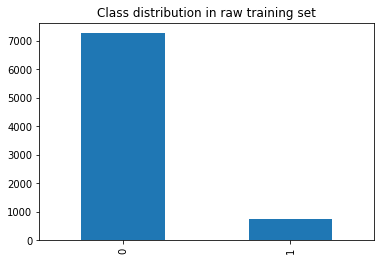

In [20]:
print(f"{sum(y_train)} positive cases out of a full set of {len(y_train)} in the training set ({round(sum(y_train)*100/len(y_train), 2)}%).")
pd.Series(y_train).value_counts().plot(kind='bar', title='Class distribution in raw training set')

## BONUS: Dictionary Generation and Extension



In [21]:
# define a very basic dictionary
seed_dict = ["muslim", "muslims", "islam", "islamic", "shiite", "sunni"]

In [22]:
# load embeddings from gensim
import gensim.downloader as api

model = api.load("glove-wiki-gigaword-100") # takes a minute or two

In [23]:
# find most similar words
pd.DataFrame(model.most_similar('muslim'))

,0,1
0,moslem,0.862341
1,muslims,0.838119
2,islamic,0.837353
3,shiite,0.784967
4,sunni,0.776142
5,religious,0.772651
6,fundamentalist,0.751274
7,militant,0.730902
8,christians,0.717026
9,arab,0.710104


In [24]:
# extend dictionary more systematically
cutoff = 0.7

from copy import deepcopy
extended_dict = deepcopy(seed_dict) # this is necessary because python's = is a bit weird

for sw in seed_dict:
  dump = pd.DataFrame(model.most_similar(sw, topn = 50))
  extended_dict.extend([w for w in dump.loc[dump[1] > cutoff, 0]])


# Count Terms

In [25]:
print(extended_dict) # ideally we would clean this a little more

['muslim', 'muslims', 'islam', 'islamic', 'shiite', 'sunni', 'moslem', 'muslims', 'islamic', 'shiite', 'sunni', 'religious', 'fundamentalist', 'militant', 'christians', 'arab', 'extremists', 'christians', 'moslems', 'muslim', 'hindus', 'shiites', 'arabs', 'jews', 'buddhists', 'catholics', 'croats', 'moslem', 'sunnis', 'sikhs', 'islamic', 'christianity', 'religion', 'muslim', 'fundamentalist', 'islamist', 'militant', 'religious', 'extremist', 'islam', 'secular', 'fundamentalists', 'radical', 'jihad', 'militants', 'extremists', 'clerics', 'sunni', 'shiites', 'sadr', 'muslim', "shi'ite", 'sunnis', 'shia', 'cleric', 'moslem', 'clerics', 'kurdish', 'najaf', 'iraqi', 'shiite', 'sunnis', 'shiites', 'muslim', 'shia', "shi'ite", 'clerics']


In [26]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from tqdm import tqdm

dict_freq = []

for doc in tqdm(_____):
  ______ = _
  for w in _____(doc):
    if w.lower() in ____:
      counter += 1
  dict_freq.____(counter)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


100%|██████████| 8000/8000 [00:36<00:00, 218.77it/s]


[]

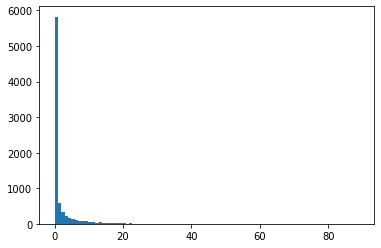

In [27]:
import matplotlib.pyplot as plt
plt.hist(dict_freq, bins = max(dict_freq)+1)
plt.plot()

## Sampling

In [28]:
# generate three different samples based on value counts
sample_size = 300
cutoff= 3
dict_freq = pd.DataFrame(dict_freq) # transform for easier handling

sample_id = pd.DataFrame([0]*len(dict_freq)) # set all ids to 0

sample_id[____ > 0 & (____ <= _____)] = 1
sample_id[dict_freq > cutoff] = 2
sample_id.value_counts()

0    5825
1    1113
2    1062
dtype: int64

In [29]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop = True)

# sample randomly from each group
low_sample_ids = sample_id[____[0] == 0].sample(____).index
mid_sample_ids = sample_id[sample_id[0] == 1].sample(sample_size).index
high_sample_ids = sample_id[sample_id[0] == 2].sample(sample_size).index


sample_low  = X_train[_____]
sample_mid  = X_train[mid_sample_ids]
sample_high = X_train[high_sample_ids]

# same for labels
y_low  = y_train[low_sample_ids]
y_mid  = y_train[mid_sample_ids]
y_high = y_train[high_sample_ids]

X_train_informed = pd.concat([sample_low, sample_mid, sample_high])
y_train_informed = pd.concat([y_low, y_mid, y_high])

In [34]:
round(sum(y_train_informed)/len(y_train_informed), 2)

0.2

In [35]:
# compare to random sample
rd_sample_ids = X_train.sample(sample_size*3).index
X_train_random = X_train[rd_sample_ids]
y_train_random = y_train[rd_sample_ids]
round(sum(y_train_random)/len(y_train_random), 2)

0.09

## Classification

In [36]:
# compare classifier performance
from sklearn.feature_extraction.text import _____
from sklearn.pipeline import Pipeline
from sklearn.linear_model import _____
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

# random sample
pipe_random = Pipeline([('count', ___), ('LogReg', ____)])
pipe_random.fit(X_train_random, y_train_random)

# informed sample
pipe_informed = Pipeline([('count', ____), ('LogReg', _____)])
pipe_informed.fit(X_train_informed, y_train_informed)

Pipeline(steps=[('count', TfidfVectorizer()),
                ('LogReg', LogisticRegression(max_iter=1000))])

In [37]:
def accuracy_report(y_test, y_pred):
  print("Accuracy: ",  round(accuracy_score(y_test, y_pred), 3))
  print("Recall: ",    round(recall_score(y_test, y_pred), 3))
  print("Precision: ", round(precision_score(y_test, y_pred), 3))
  print("F1: ",        round(f1_score(y_test, y_pred), 3))

How well do the classifiers perform? We start with the assessment of the classifier trained on random data:

In [38]:
accuracy_report(_____, pipe_random._____(X_test))

Accuracy:  0.93
Recall:  0.127
Precision:  0.952
F1:  0.223


In [39]:
pd._____(y_test, pipe_random.predict(X_test))

col_0,0,1
muslim_identity,,
0,1841,1
1,138,20


In [40]:
accuracy_report(y_test, pipe_informed.predict(X_test)) # much better  

Accuracy:  0.944
Recall:  0.316
Precision:  0.926
F1:  0.472


In [41]:
pd.crosstab(y_test, pipe_informed.predict(X_test))

col_0,0,1
muslim_identity,,
0,1838,4
1,108,50


This looks much better with our informed sample. While precision is only marginally lower, recall is much higher, resulting in an overall higher F1 score. Overall accuracy is even better.

Clearly, stratified dictionary sampling can help reduce problems with imbalanced data. However, we don't need to stop here. The stratified sample could be enhanced with further under- and [oversampling](https://colab.research.google.com/github/nicolaiberk/Imbalanced/blob/master/02b_SMOTE_Solution.ipynb) or serve as input for an [active learning pipeline](https://colab.research.google.com/github/nicolaiberk/Imbalanced/blob/master/02c_ActiveLearning_Solution.ipynb).